In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from opfunu.cec_based import cec2014, cec2017, cec2020, cec2022
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm


In [6]:
# !pip install opfunu

In [ ]:
def mvao_optimizer_with_tracking(fitness_function, bounds, dim, max_iter=500, pop_size=50, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    lb, ub = bounds
    alpha = 0.1
    delta = 0.1
    beta = 1.8
    
    positions = np.random.uniform(lb, ub, (pop_size, dim))
    fitness = np.zeros(pop_size)
    
    for i in range(pop_size):
        fitness[i] = fitness_function(positions[i])
    
    best_idx = np.argmin(fitness)
    X_best = positions[best_idx].copy()
    best_fitness = fitness[best_idx]
    
    objective_values = np.zeros((max_iter, dim))
    trajectory_x1 = np.zeros(max_iter)
    convergence_curve = np.zeros(max_iter)
    
    objective_values[0] = X_best
    trajectory_x1[0] = positions[0, 0]
    convergence_curve[0] = best_fitness
    
    for iter in range(1, max_iter):
        weights = 1 / (fitness + np.finfo(float).eps)
        weighted_mean = np.sum(positions * weights[:, np.newaxis], axis=0) / np.sum(weights)
        
        for i in range(pop_size):
            if iter <= (2/3) * max_iter:
                if np.random.rand() < 0.5:
                    positions[i] = X_best * (1 - iter / max_iter) + (weighted_mean - X_best) * np.random.rand()
                else:
                    r = np.random.rand()
                    theta = np.random.rand() * 2 * np.pi
                    x = r * np.sin(theta)
                    y = r * np.cos(theta)
                    
                    sigma = (np.math.gamma(1+beta)*np.sin(np.pi*beta/2)/(np.math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)
                    u = np.random.randn(dim) * sigma
                    v = np.random.randn(dim)
                    levy = 0.01 * u / np.abs(v)**(1/beta)
                    
                    positions[i] = X_best * levy + positions[np.random.randint(pop_size)] + (y - x) * np.random.rand()
            else:
                if np.random.rand() < 0.5:
                    positions[i] = (X_best * weighted_mean) * alpha - np.random.rand() + ((ub - lb) * np.random.rand() + lb) * delta
                else:
                    QF = iter**((2*np.random.rand()-1)/(1 - max_iter)**2)
                    G1 = 2 * np.random.rand() - 1
                    G2 = 2 * (1 - iter / max_iter)
                    levy = np.random.rand(dim)
                    
                    positions[i] = QF * X_best - G1 * positions[i] * np.random.rand() - G2 * levy + np.random.rand(dim)
            
            positions[i] = np.where(positions[i] < lb, 2 * lb - positions[i], positions[i])
            positions[i] = np.where(positions[i] > ub, 2 * ub - positions[i], positions[i])
            positions[i] = np.clip(positions[i], lb, ub)
            
            fitness[i] = fitness_function(positions[i])
            
            if fitness[i] < best_fitness:
                best_fitness = fitness[i]
                X_best = positions[i].copy()
        
        objective_values[iter] = X_best
        trajectory_x1[iter] = positions[0, 0]
        convergence_curve[iter] = best_fitness
    
    return X_best, best_fitness, objective_values, trajectory_x1, convergence_curve


In [8]:
def plot_single_function_analysis(objective_values, trajectory, convergence_curve, function_name="Function", save_path=None):
    """
    Create a three-panel visualization showing:
    1. Objective values (each dimension over iterations)
    2. Trajectory of 1st solution's first dimension
    3. Convergence curve (log scale)
    """
    iterations = np.arange(1, len(convergence_curve) + 1)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Objective values
    plt.subplot(1, 3, 1)
    dim = objective_values.shape[1]
    colors = plt.cm.tab10(np.linspace(0, 1, dim))
    
    for i in range(dim):
        plt.plot(iterations, objective_values[:, i], color=colors[i], label=f'x{i+1}')
    
    plt.xlabel('Iteration#')
    plt.ylabel('Value')
    plt.title('Objective values')
    plt.grid(True, alpha=0.3)
    if dim <= 10:  # Only show legend if not too many dimensions
        plt.legend()
    
    # Plot 2: Trajectory of 1st solution
    plt.subplot(1, 3, 2)
    plt.plot(iterations, trajectory, color='blue')
    plt.xlabel('Iteration#')
    plt.ylabel('Value')
    plt.title('Trajectory of 1st Sol.')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Convergence curve (log scale)
    plt.subplot(1, 3, 3)
    plt.semilogy(iterations, convergence_curve, color='green')
    plt.xlabel('Iteration#')
    plt.ylabel('Best fitness function')
    plt.title('Convergence curve')
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'MVAO Performance on {function_name}', fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


In [9]:
def plot_multiple_functions_comparison(results_dict, suite_name, save_path=None):
    """
    Create a grid of convergence plots for multiple functions from the same CEC suite.
    
    Parameters:
    -----------
    results_dict : dict
        Dictionary with function names as keys and convergence curves as values
    suite_name : str
        Name of the CEC suite (e.g., "CEC2014")
    save_path : str, optional
        Path to save the figure
    """
    num_funcs = len(results_dict)
    rows = int(np.ceil(num_funcs / 3))
    cols = min(3, num_funcs)
    
    fig = plt.figure(figsize=(15, 5 * rows))
    
    for i, (func_name, curve) in enumerate(results_dict.items()):
        ax = plt.subplot(rows, cols, i + 1)
        
        # Plot convergence curve with log scale
        iterations = np.arange(len(curve))
        ax.semilogy(iterations, curve, 'k-', linewidth=1.5)
        
        ax.set_title(func_name)
        ax.set_xlabel('No. of Iterations')
        ax.set_ylabel('Fitness function')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'MVAO Convergence on {suite_name} Functions', fontsize=16, y=1.02)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()


In [10]:
def run_cec_experiments(suite_name, func_indices, dimensions=30, max_iter=500, 
                        pop_size=50, runs=1, save_dir='results'):
    """
    Run MVAO on selected CEC benchmark functions and generate visualizations.
    
    Parameters:
    -----------
    suite_name : str
        Name of the CEC suite ('CEC2014', 'CEC2017', 'CEC2020', 'CEC2022')
    func_indices : list
        List of function indices to evaluate
    dimensions : int
        Dimensionality of the problems (default: 30)
    max_iter : int
        Maximum iterations per run (default: 500)
    pop_size : int
        Population size (default: 50)
    runs : int
        Number of independent runs (default: 1)
    save_dir : str
        Directory to save results
    """
    # Create directory for results if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Select the appropriate CEC suite
    if suite_name == 'CEC2014':
        suite_module = cec2014
        max_func = 30
        if dimensions > 100:  # CEC2014 supports up to 100D
            dimensions = 100
            print("Warning: CEC2014 supports max 100D, setting dimensions to 100")
    elif suite_name == 'CEC2017':
        suite_module = cec2017
        max_func = 30
    elif suite_name == 'CEC2020':
        suite_module = cec2020
        max_func = 10
    elif suite_name == 'CEC2022':
        suite_module = cec2022
        max_func = 12
        if dimensions > 20:  # CEC2022 supports up to 20D
            dimensions = 20
            print("Warning: CEC2022 supports max 20D, setting dimensions to 20")
    else:
        raise ValueError(f"Unknown suite: {suite_name}")
    
    # Validate function indices
    func_indices = [i for i in func_indices if 1 <= i <= max_func]
    if not func_indices:
        raise ValueError(f"No valid function indices for {suite_name}")
    
    # Dictionary to store convergence curves for multiple function comparison
    all_convergence_curves = {}
    
    # Run experiments for each function
    for func_idx in tqdm(func_indices, desc=f"Running {suite_name} functions"):
        # Get function class
        func_name = f"F{func_idx}"
        try:
            func_class = getattr(suite_module, f"{func_name}{suite_name[-4:]}")
            func_obj = func_class(ndim=dimensions)
            lb, ub = func_obj.lb, func_obj.ub
        except:
            print(f"Error loading {func_name} from {suite_name}, skipping...")
            continue
        
        # Run MVAO multiple times and average results
        all_best_fitness = []
        all_obj_values = []
        all_trajectories = []
        all_conv_curves = []
        
        for run in range(runs):
            # Set different seed for each run
            seed = 1000 * func_idx + run
            
            # Run MVAO with tracking
            _, _, obj_values, trajectory, conv_curve = mvao_optimizer_with_tracking(
                func_obj.evaluate, [lb, ub], dimensions, max_iter, pop_size, seed
            )
            
            # Store results
            all_best_fitness.append(conv_curve[-1])
            all_obj_values.append(obj_values)
            all_trajectories.append(trajectory)
            all_conv_curves.append(conv_curve)
        
        # Average results over runs
        mean_obj_values = np.mean(all_obj_values, axis=0)
        mean_trajectory = np.mean(all_trajectories, axis=0)
        mean_conv_curve = np.mean(all_conv_curves, axis=0)
        
        # Store for multi-function comparison
        all_convergence_curves[f"{func_name}"] = mean_conv_curve
        
        # Generate and save single function analysis plot
        if runs == 1:  # Only create detailed plot for single runs
            func_save_path = os.path.join(save_dir, f"{suite_name}_{func_name}_analysis.png")
            plot_single_function_analysis(
                obj_values, trajectory, conv_curve, 
                f"{suite_name} {func_name}", func_save_path
            )
    
    # Generate and save multi-function comparison plot
    if len(all_convergence_curves) > 1:
        comparison_save_path = os.path.join(save_dir, f"{suite_name}_comparison.png")
        plot_multiple_functions_comparison(
            all_convergence_curves, suite_name, comparison_save_path
        )
    
    return all_convergence_curves



Running experiments for CEC2014...


Running CEC2014 functions:   0%|          | 0/6 [00:00<?, ?it/s]C:\Users\HARSHDIP\AppData\Local\Temp\ipykernel_19180\2182913683.py:54: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma = (np.math.gamma(1+beta)*np.sin(np.pi*beta/2)/(np.math.gamma((1+beta)/2)*beta*2**((beta-1)/2)))**(1/beta)


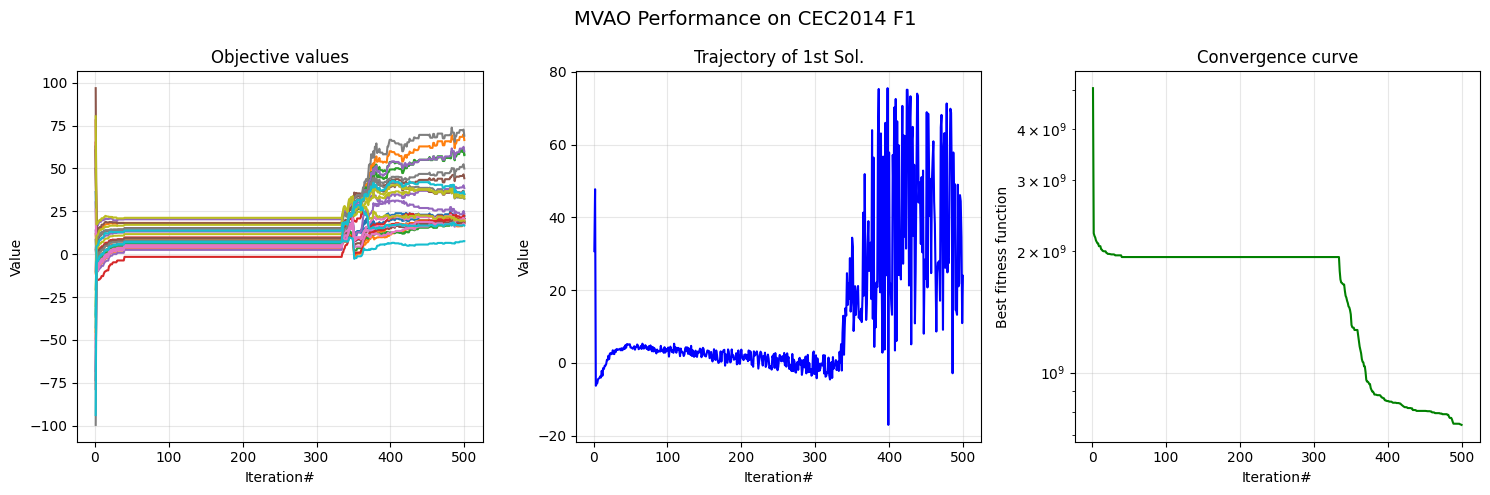

Running CEC2014 functions:  17%|█▋        | 1/6 [00:06<00:34,  6.93s/it]

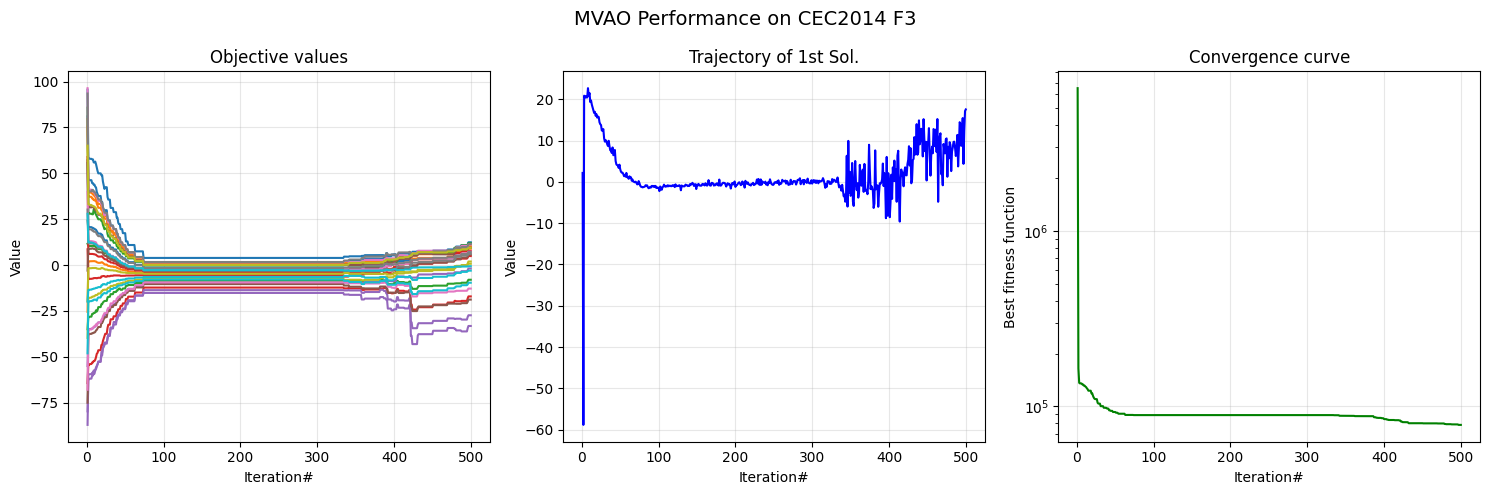

Running CEC2014 functions:  33%|███▎      | 2/6 [00:12<00:24,  6.18s/it]

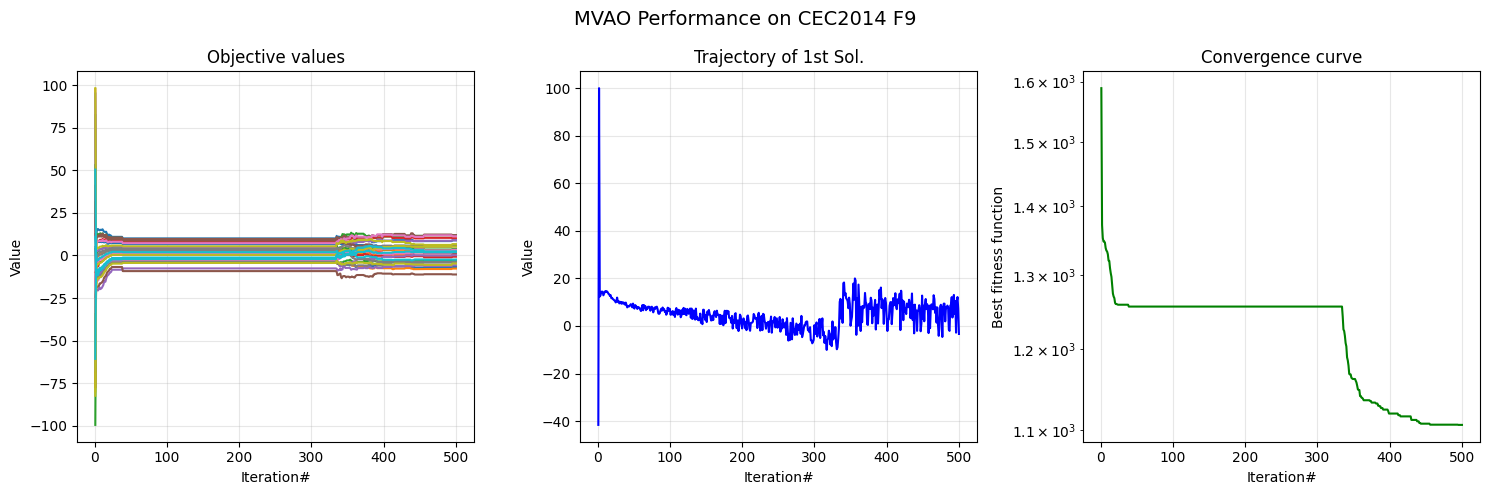

Running CEC2014 functions:  50%|█████     | 3/6 [00:18<00:18,  6.20s/it]

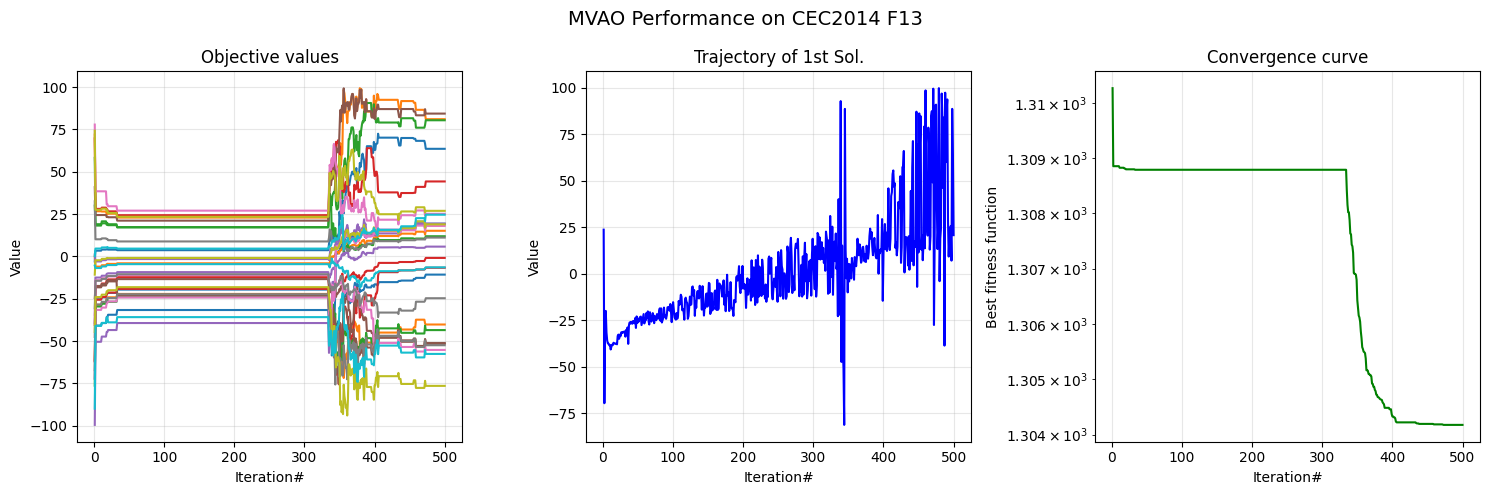

Running CEC2014 functions:  67%|██████▋   | 4/6 [00:25<00:12,  6.26s/it]

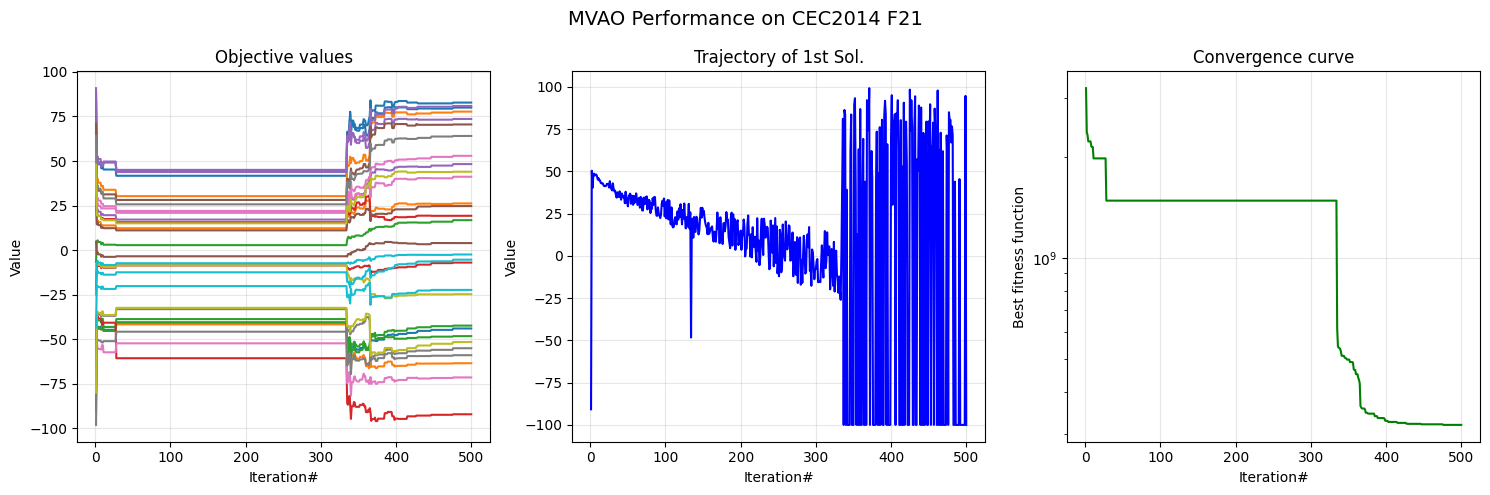

Running CEC2014 functions:  83%|████████▎ | 5/6 [00:39<00:09,  9.16s/it]

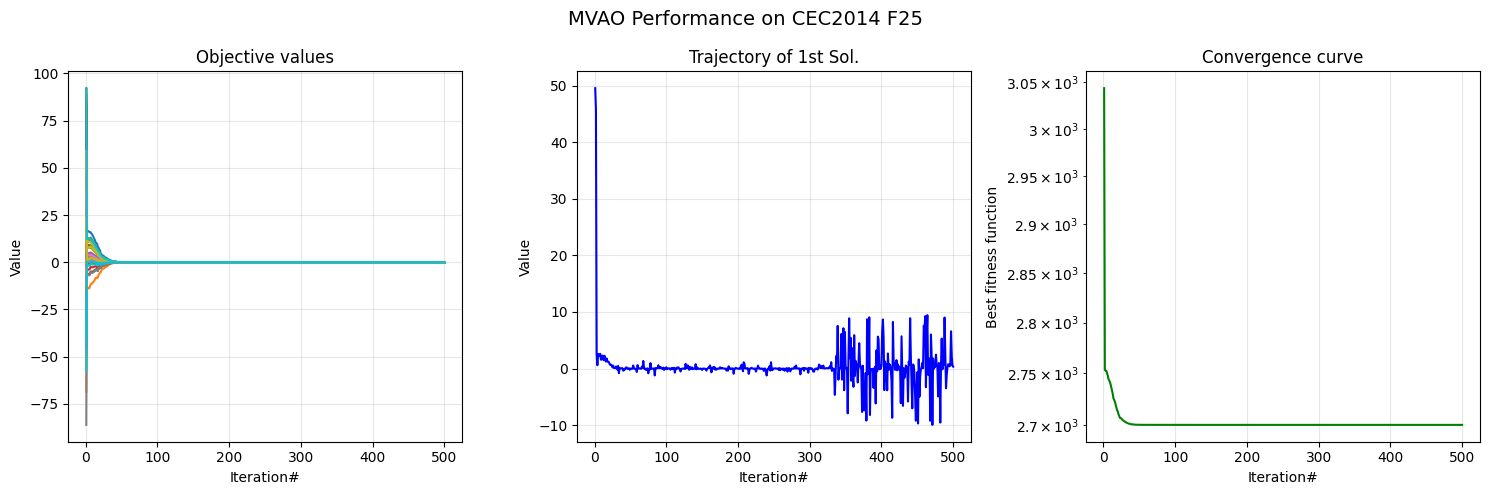

Running CEC2014 functions: 100%|██████████| 6/6 [00:55<00:00,  9.22s/it]


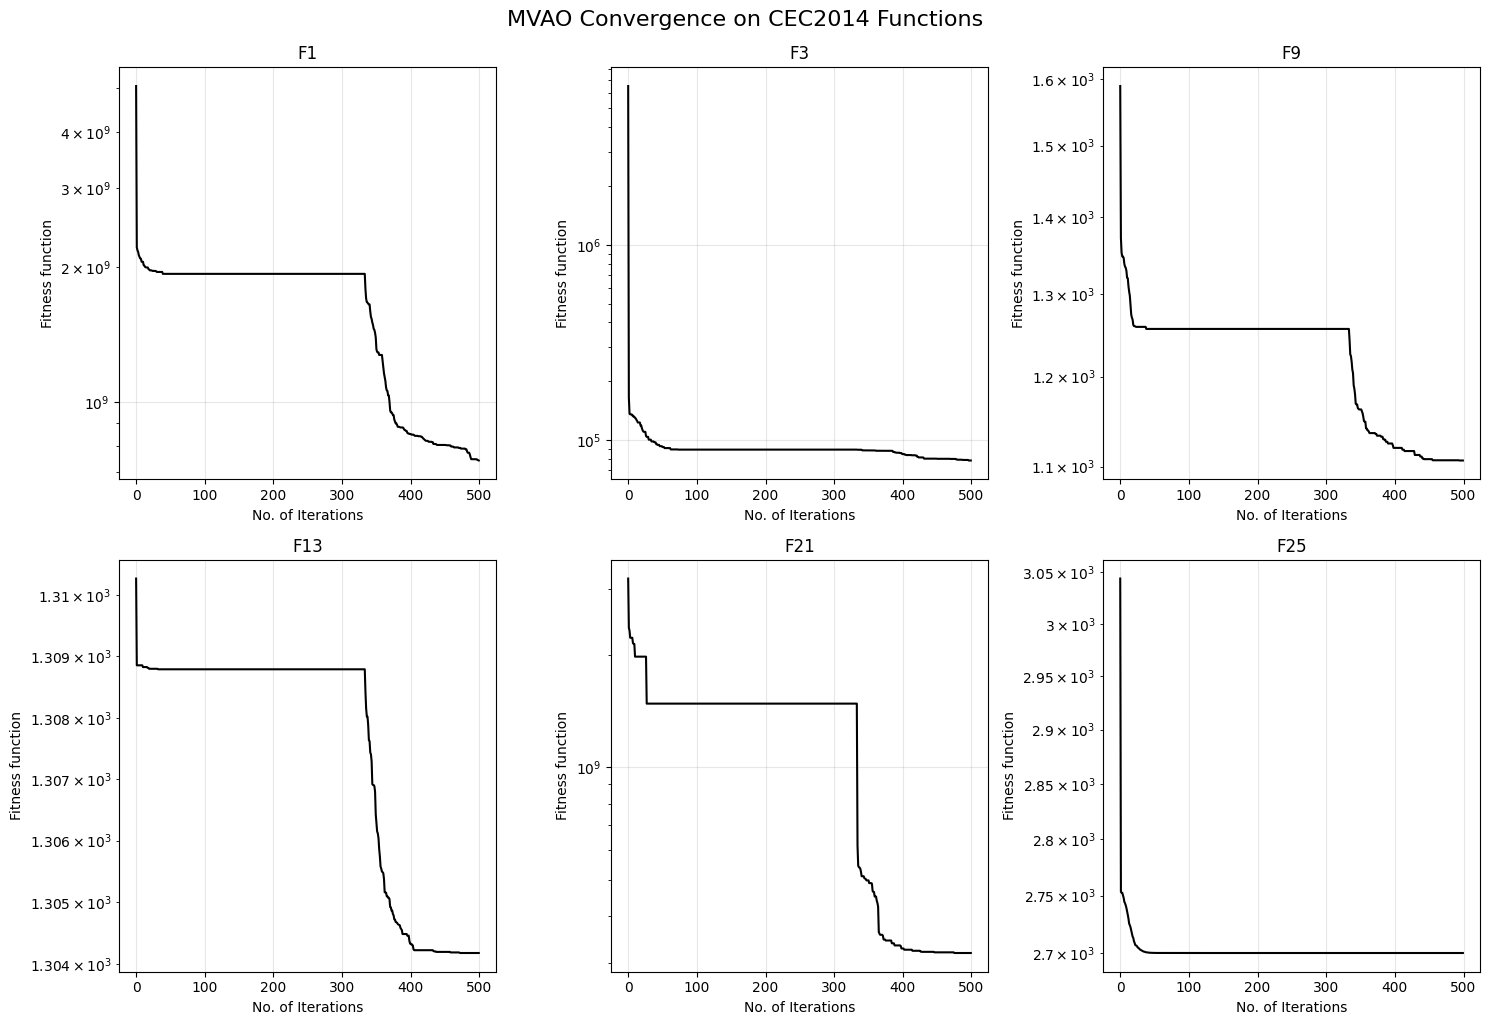


Running experiments for CEC2017...


Running CEC2017 functions:   0%|          | 0/6 [00:00<?, ?it/s]

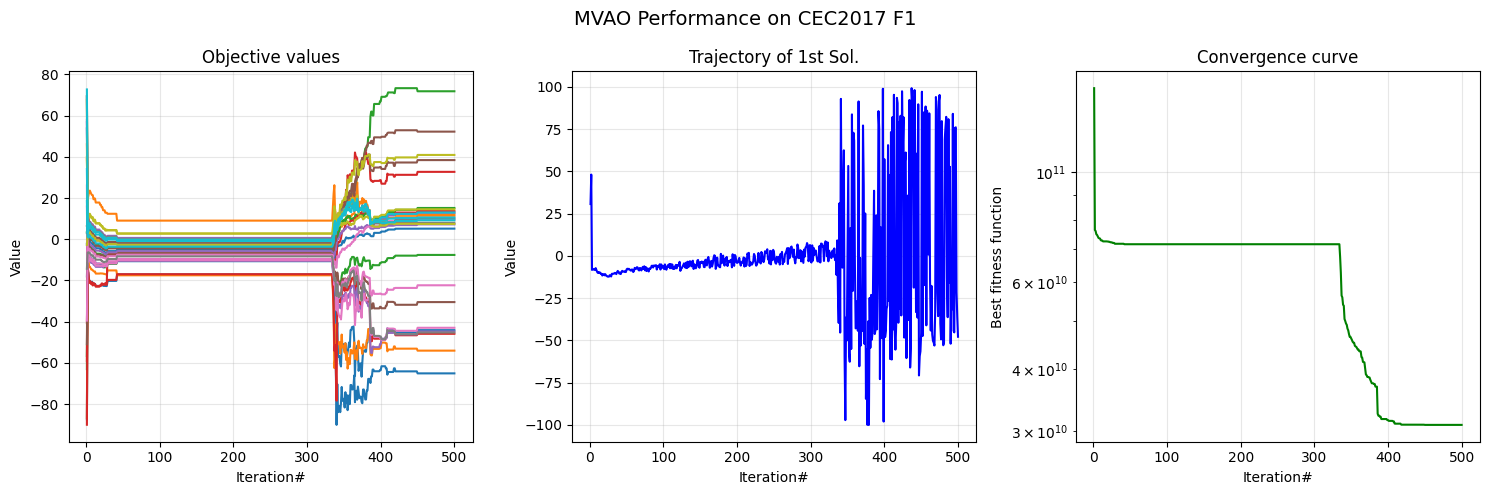

Running CEC2017 functions:  17%|█▋        | 1/6 [00:06<00:34,  6.96s/it]

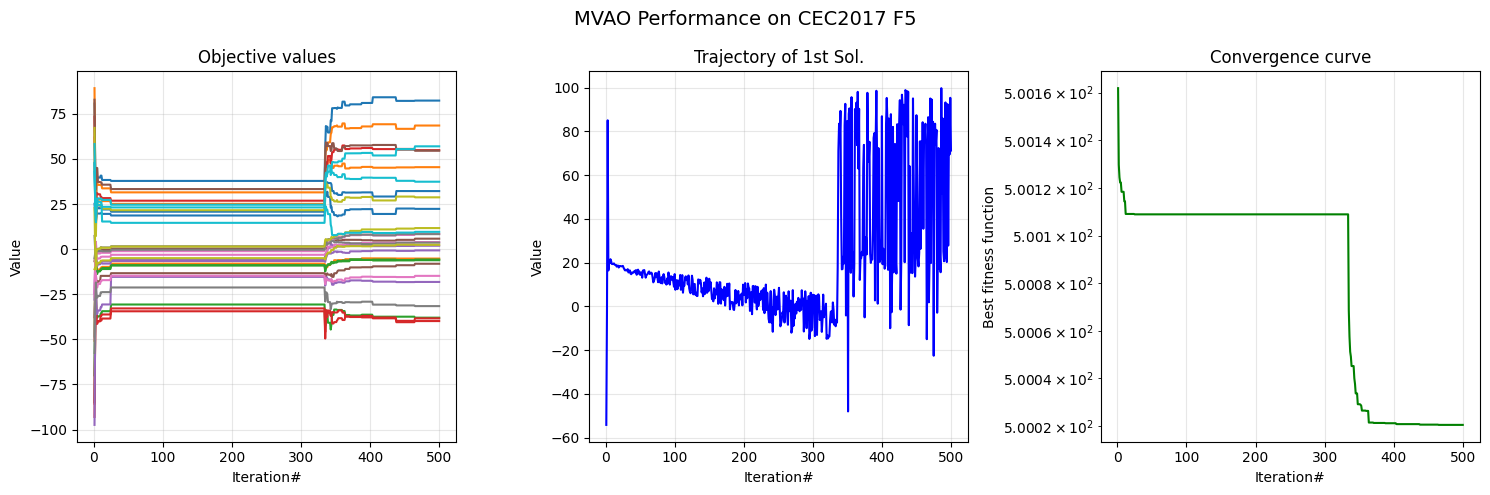

Running CEC2017 functions:  33%|███▎      | 2/6 [00:17<00:35,  8.85s/it]

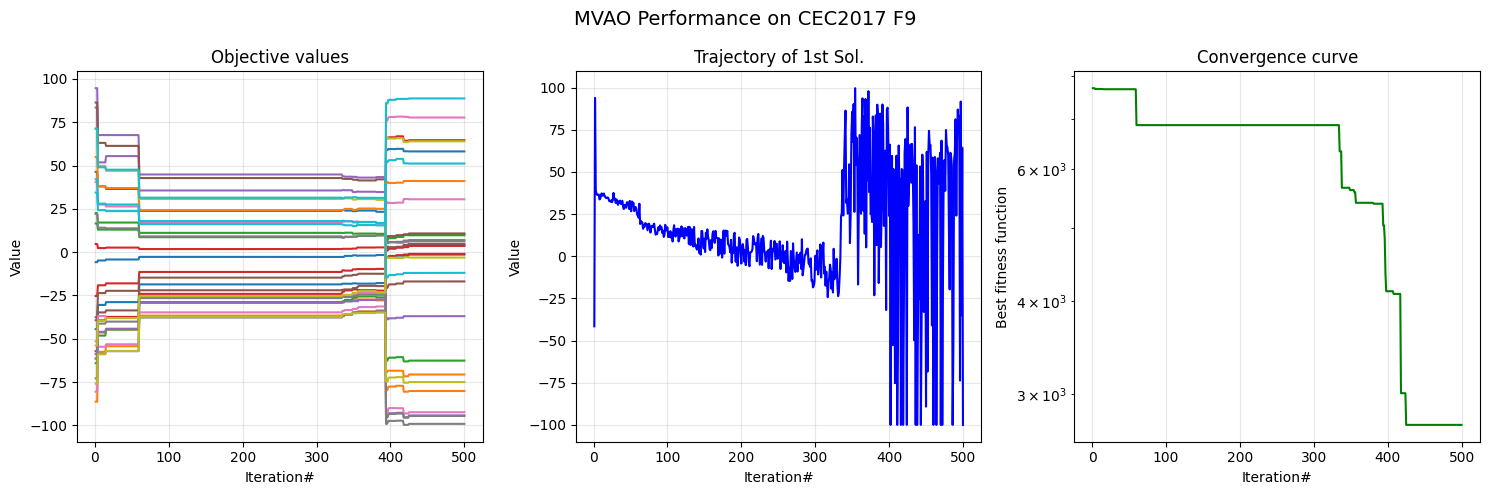

Running CEC2017 functions:  50%|█████     | 3/6 [00:25<00:25,  8.61s/it]

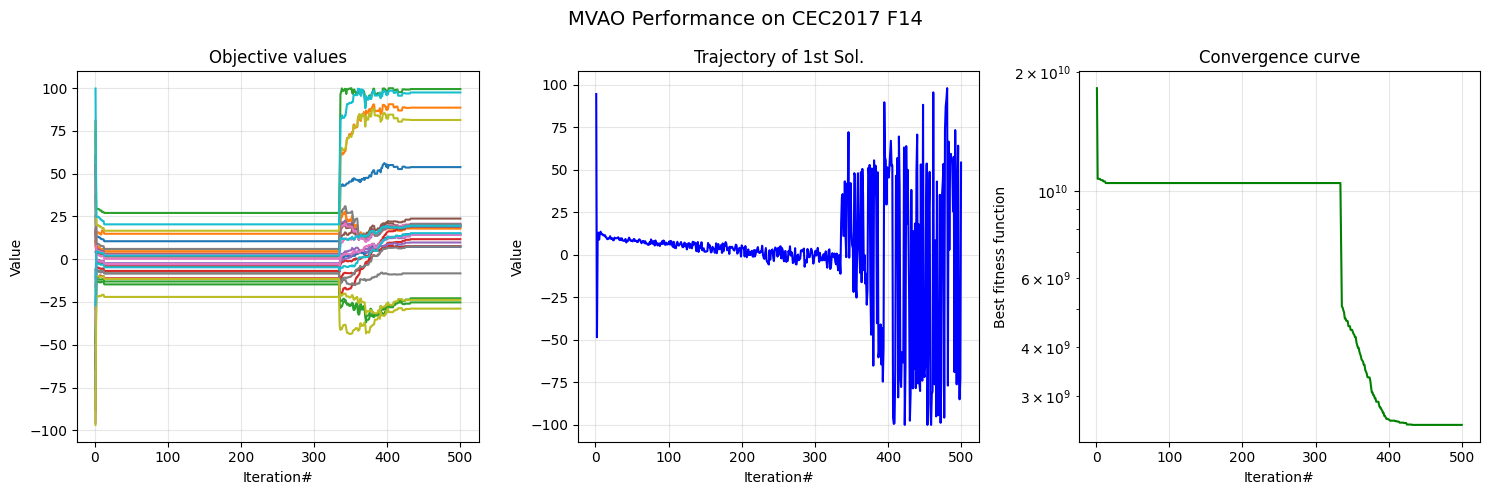

Running CEC2017 functions:  67%|██████▋   | 4/6 [00:34<00:17,  8.62s/it]

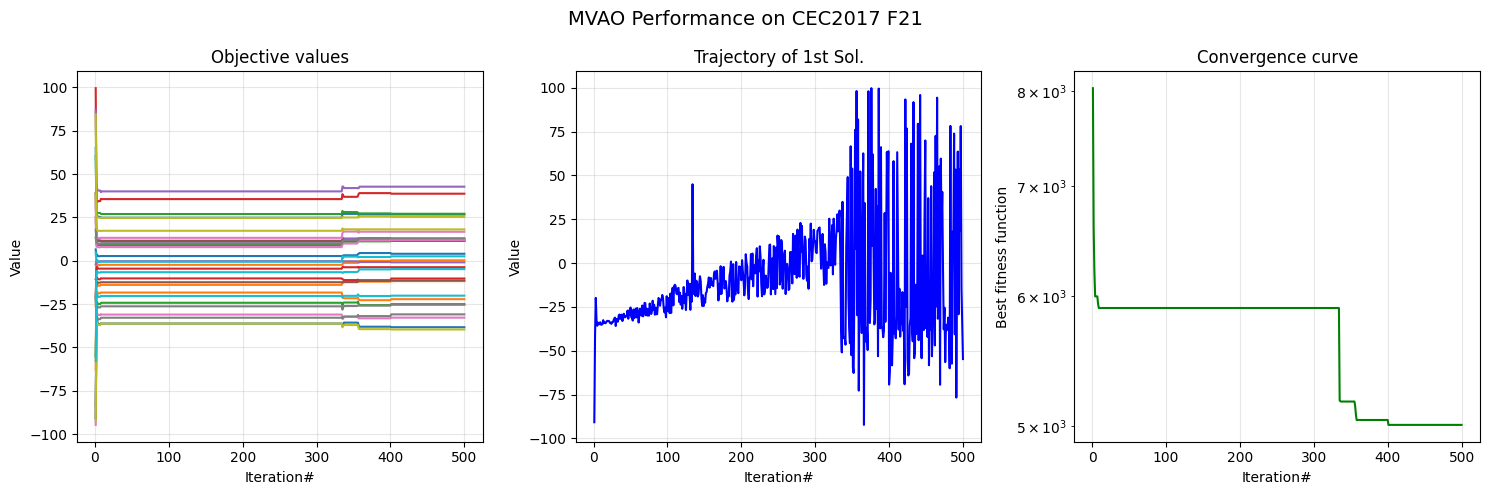

Running CEC2017 functions:  83%|████████▎ | 5/6 [00:47<00:10, 10.50s/it]

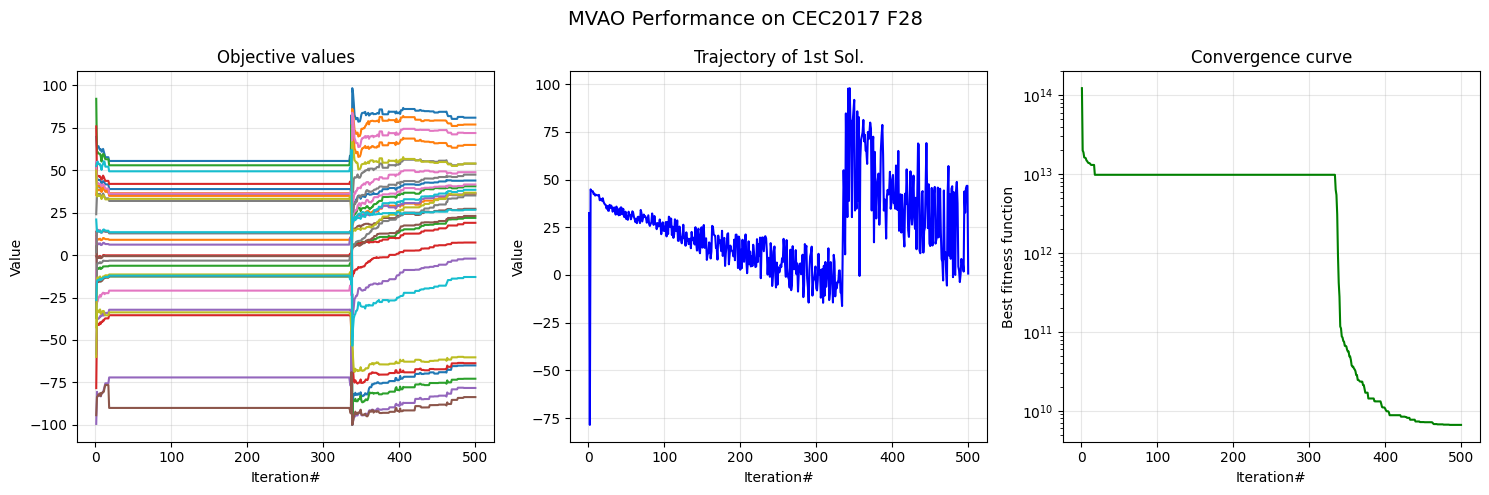

Running CEC2017 functions: 100%|██████████| 6/6 [01:48<00:00, 18.12s/it]


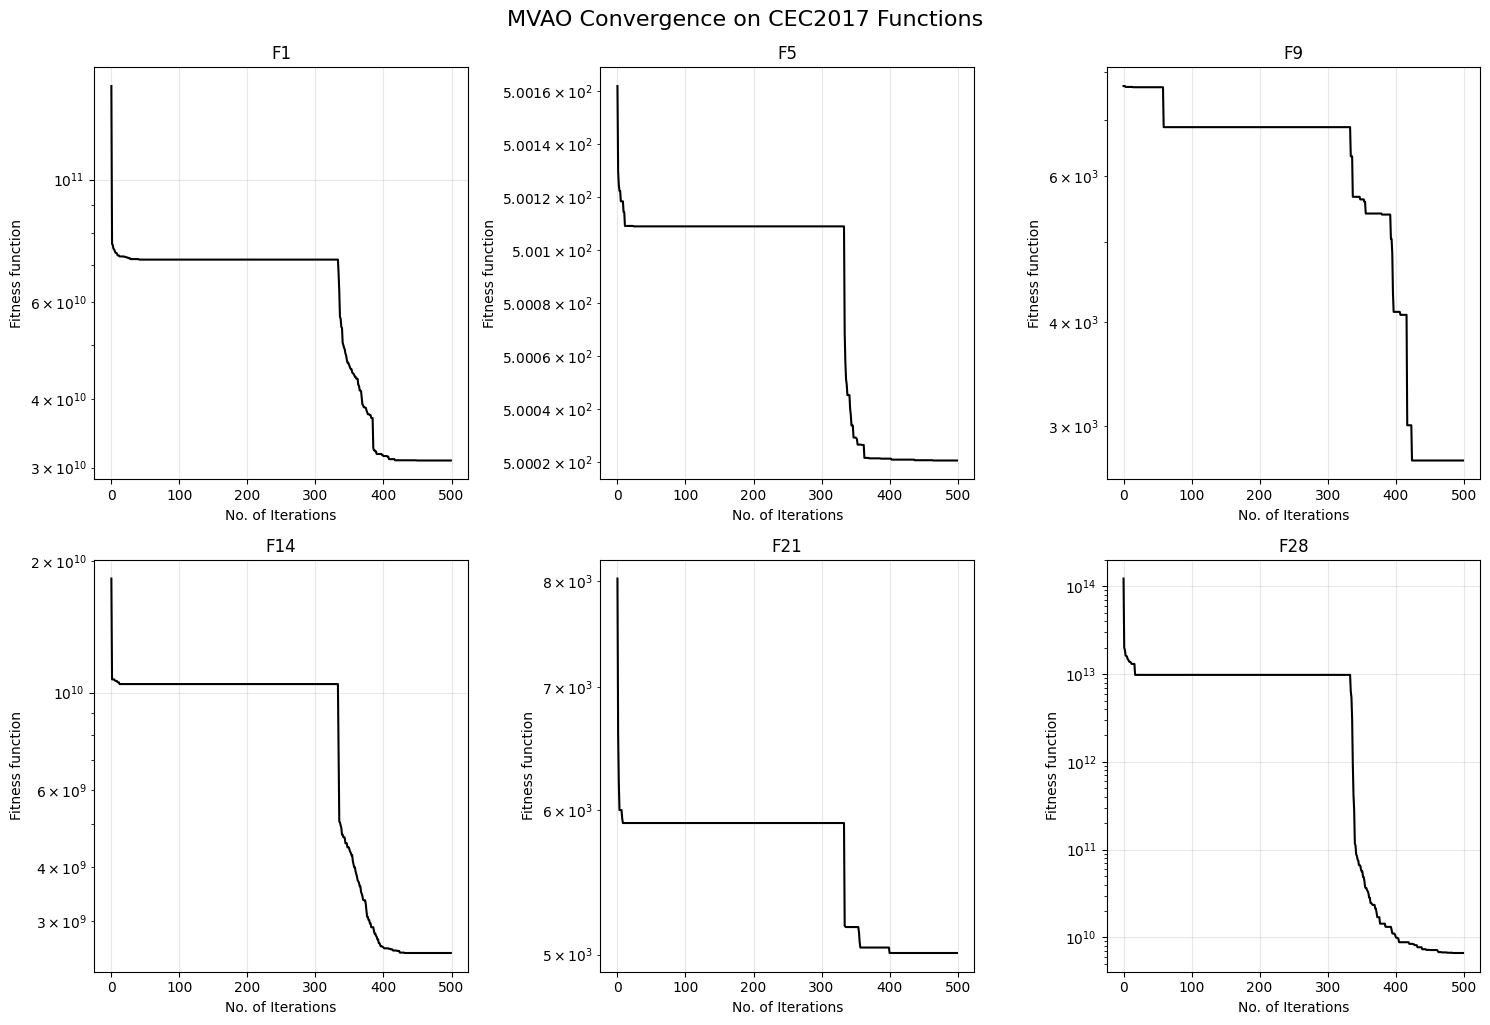


Running experiments for CEC2020...


Running CEC2020 functions:   0%|          | 0/5 [00:00<?, ?it/s]

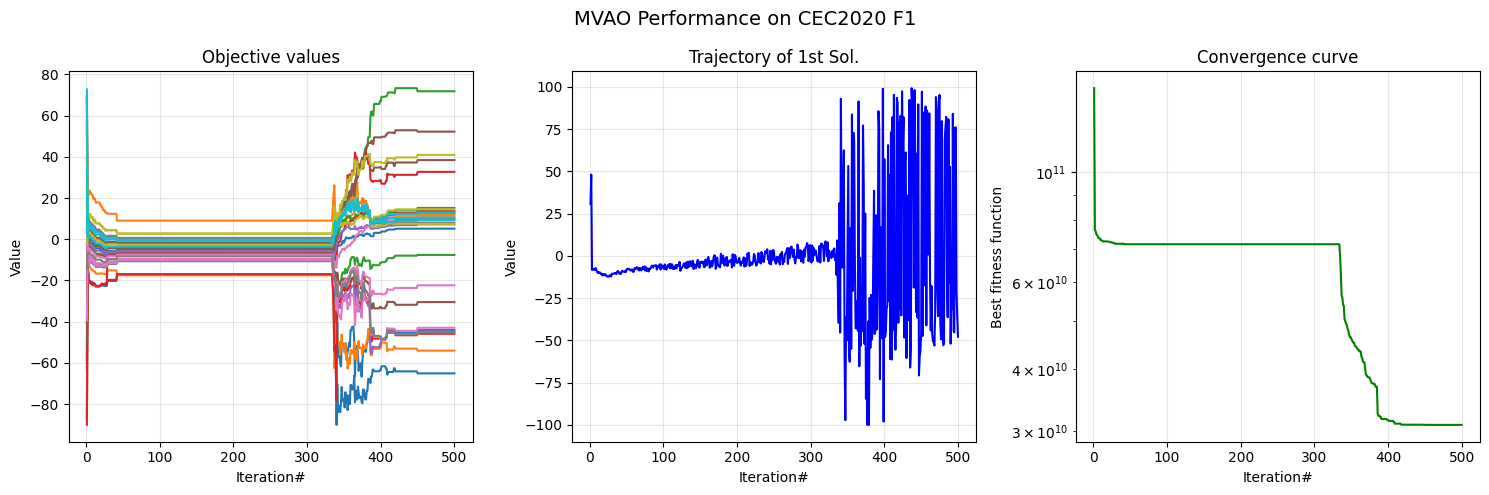

Running CEC2020 functions:  20%|██        | 1/5 [00:06<00:25,  6.26s/it]

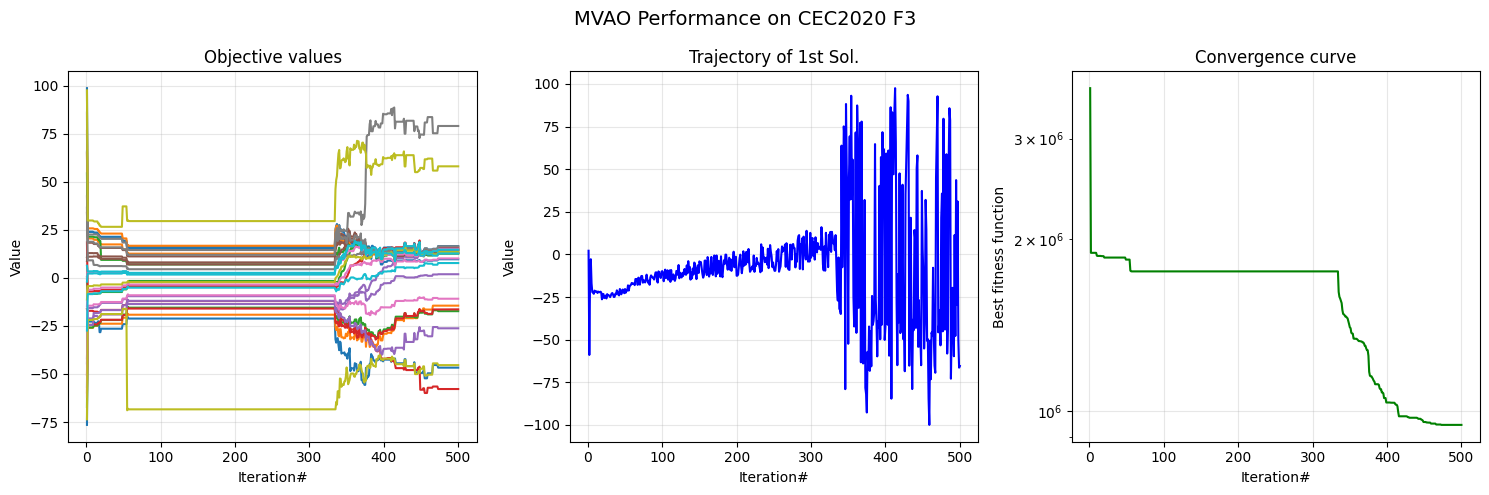

Running CEC2020 functions:  40%|████      | 2/5 [00:13<00:20,  6.72s/it]

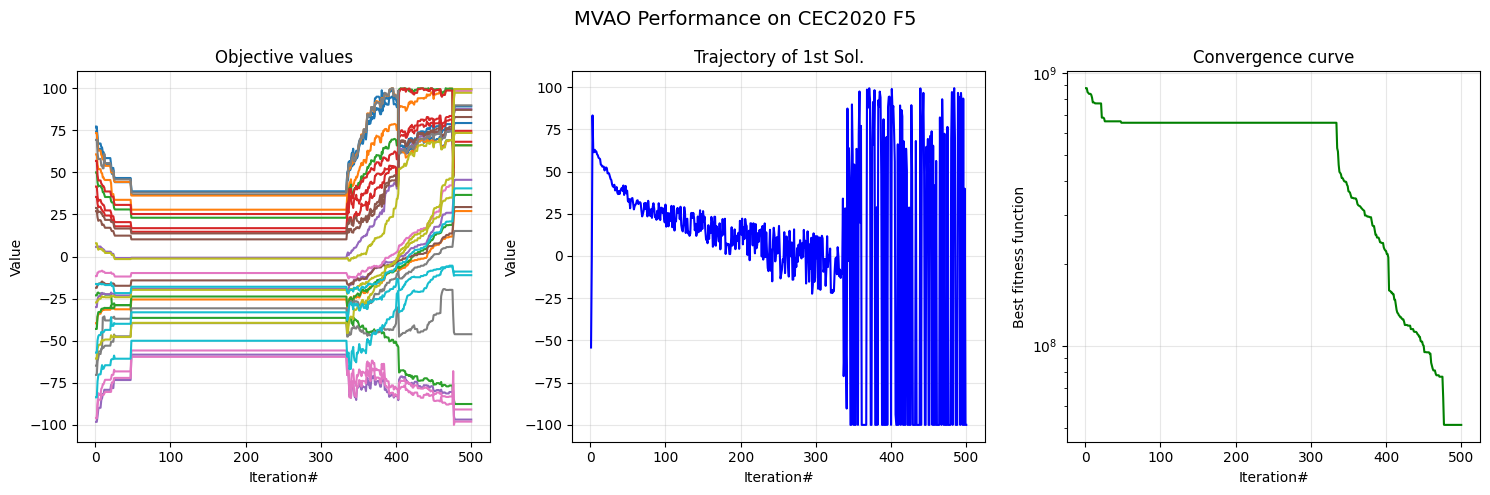

Running CEC2020 functions:  60%|██████    | 3/5 [00:25<00:18,  9.03s/it]

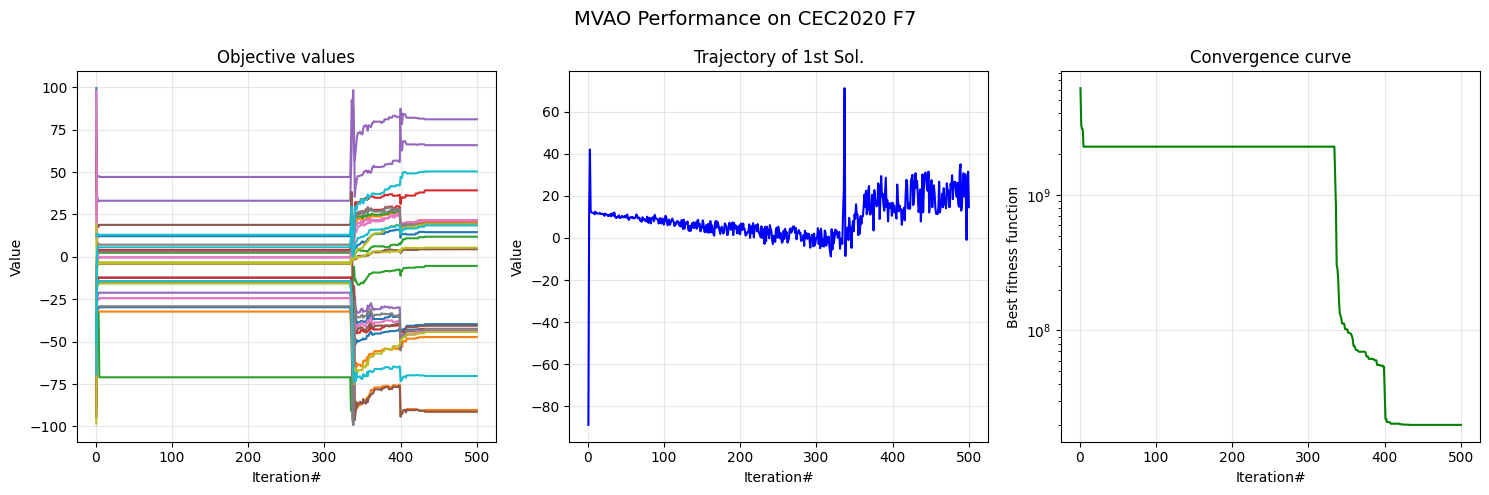

Running CEC2020 functions:  80%|████████  | 4/5 [00:39<00:11, 11.32s/it]

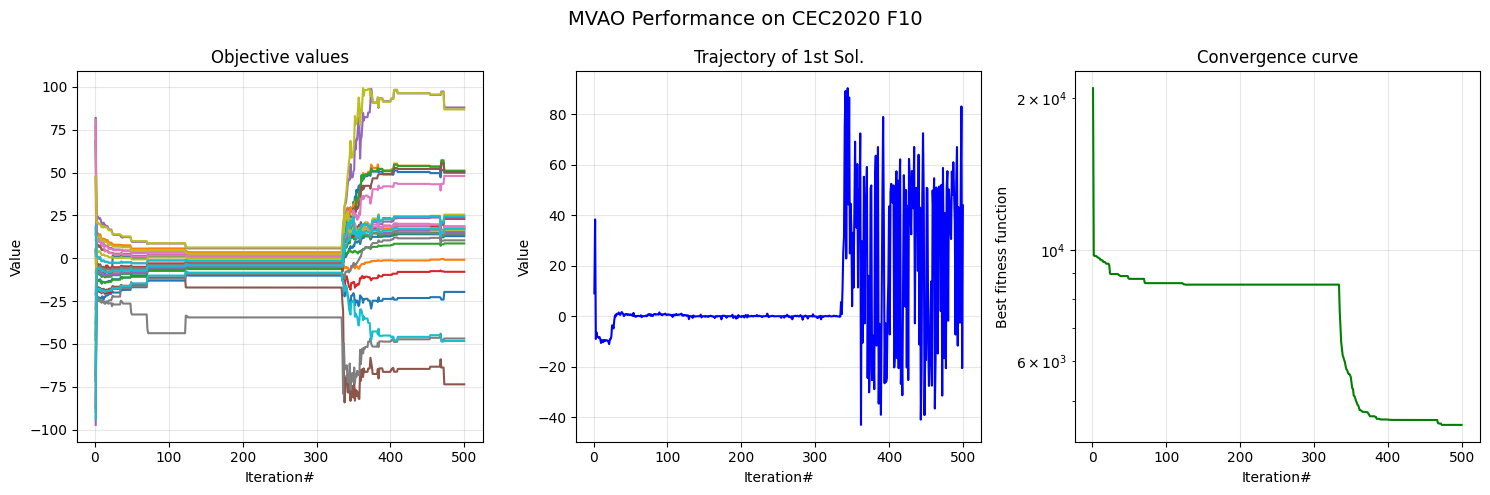

Running CEC2020 functions: 100%|██████████| 5/5 [00:52<00:00, 10.52s/it]


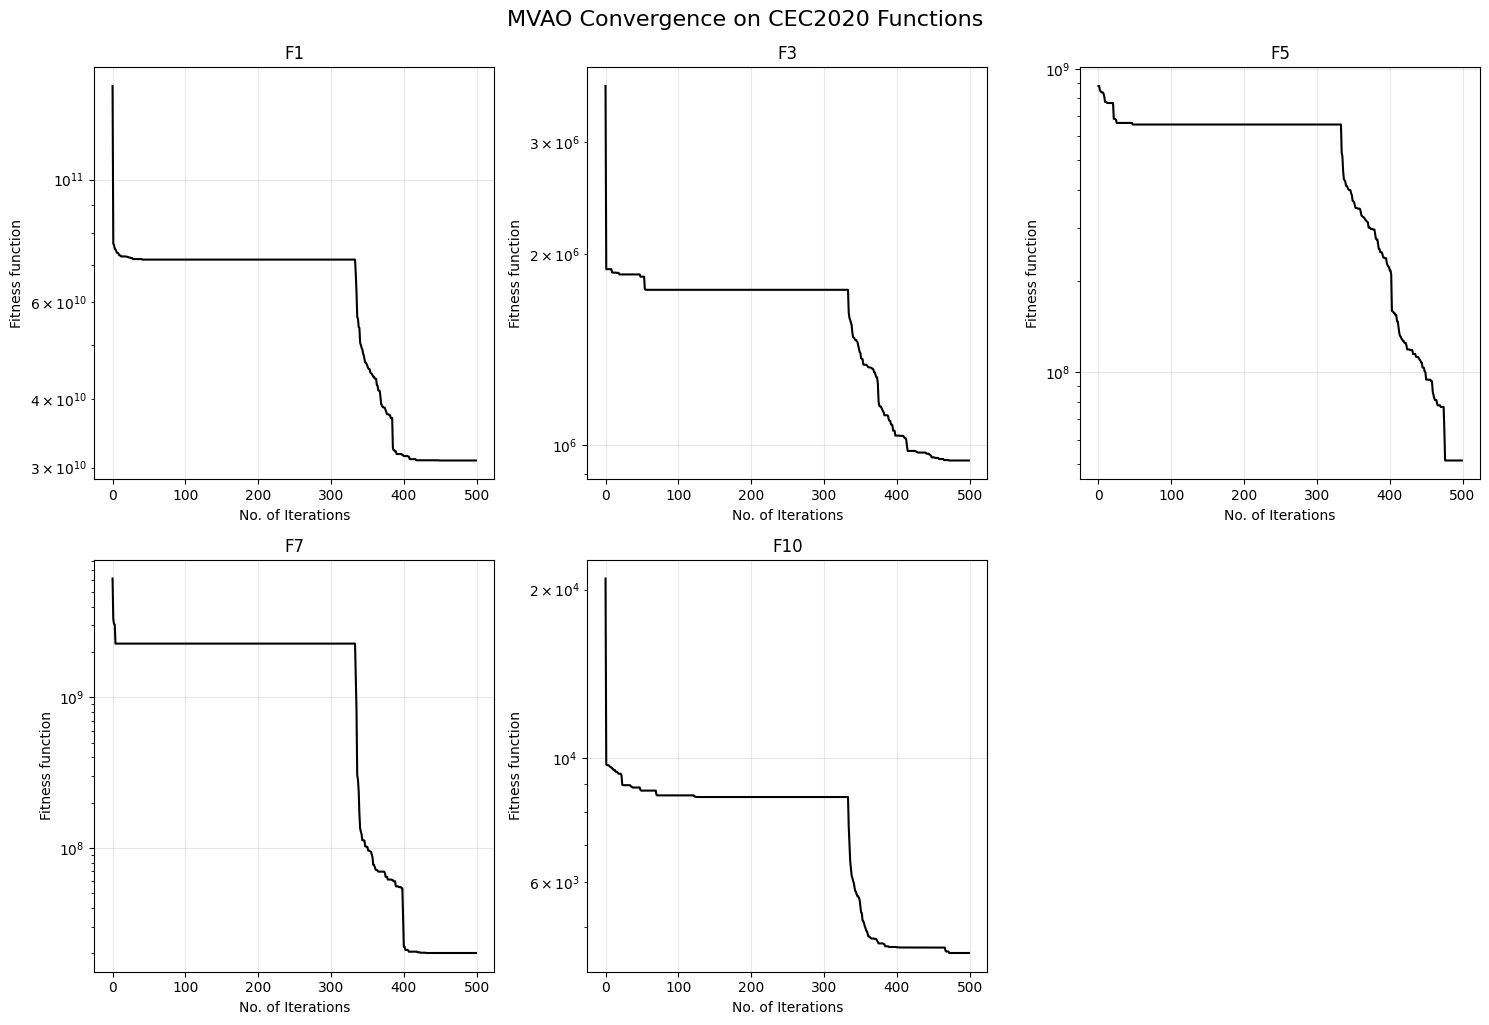


Running experiments for CEC2022...


Running CEC2022 functions:   0%|          | 0/5 [00:00<?, ?it/s]

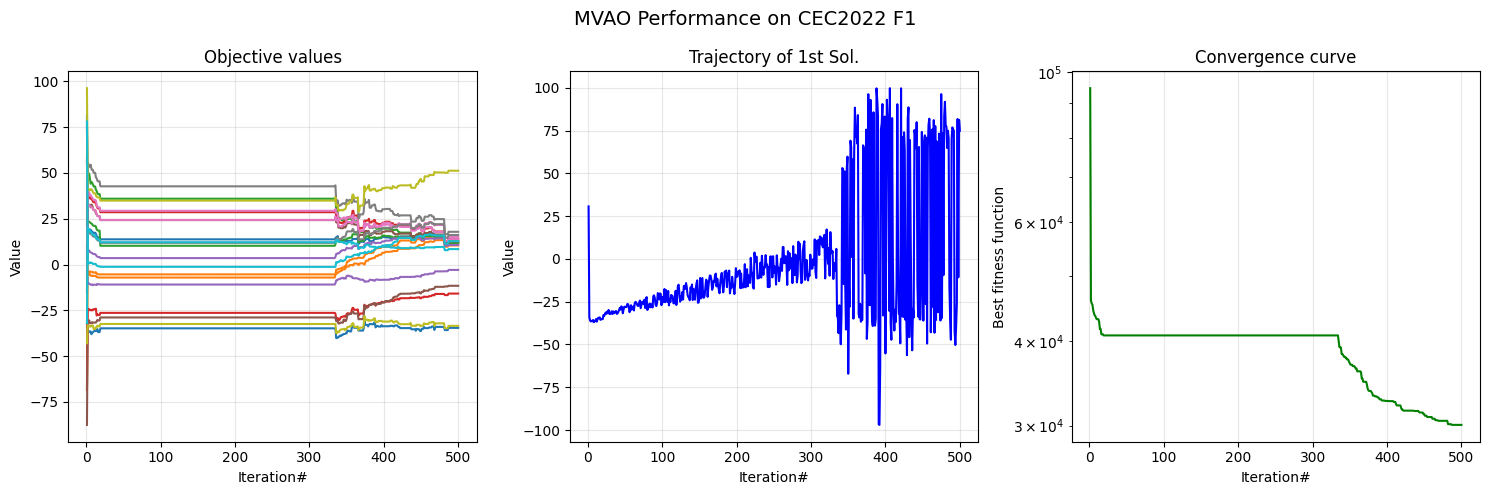

Running CEC2022 functions:  20%|██        | 1/5 [00:05<00:23,  5.88s/it]

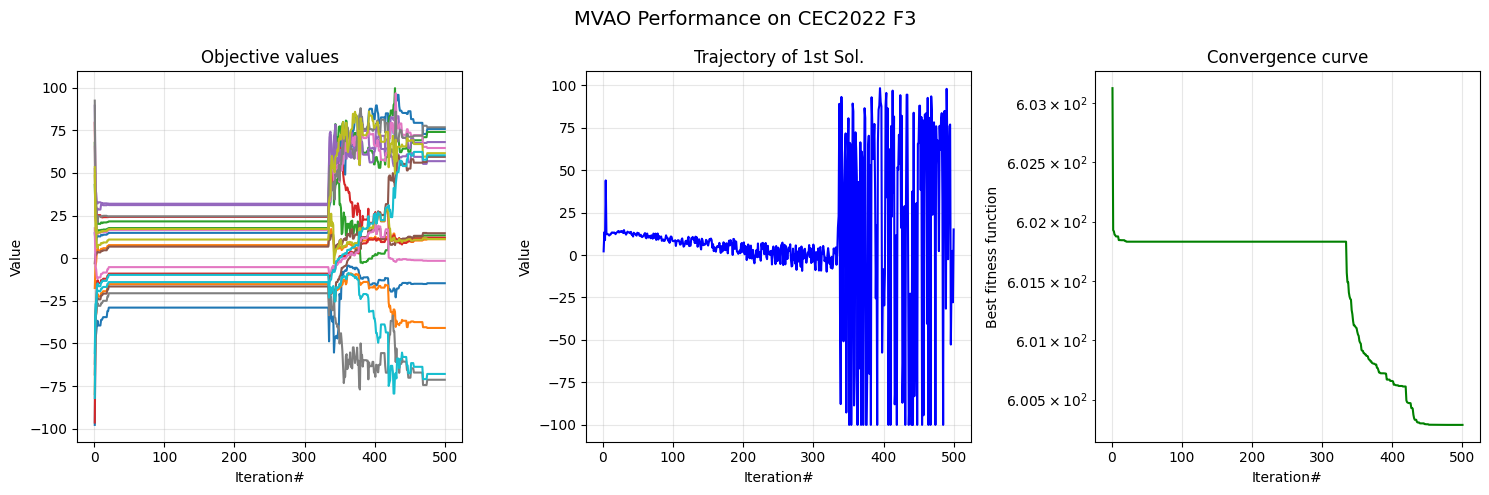

Running CEC2022 functions:  40%|████      | 2/5 [00:14<00:22,  7.43s/it]

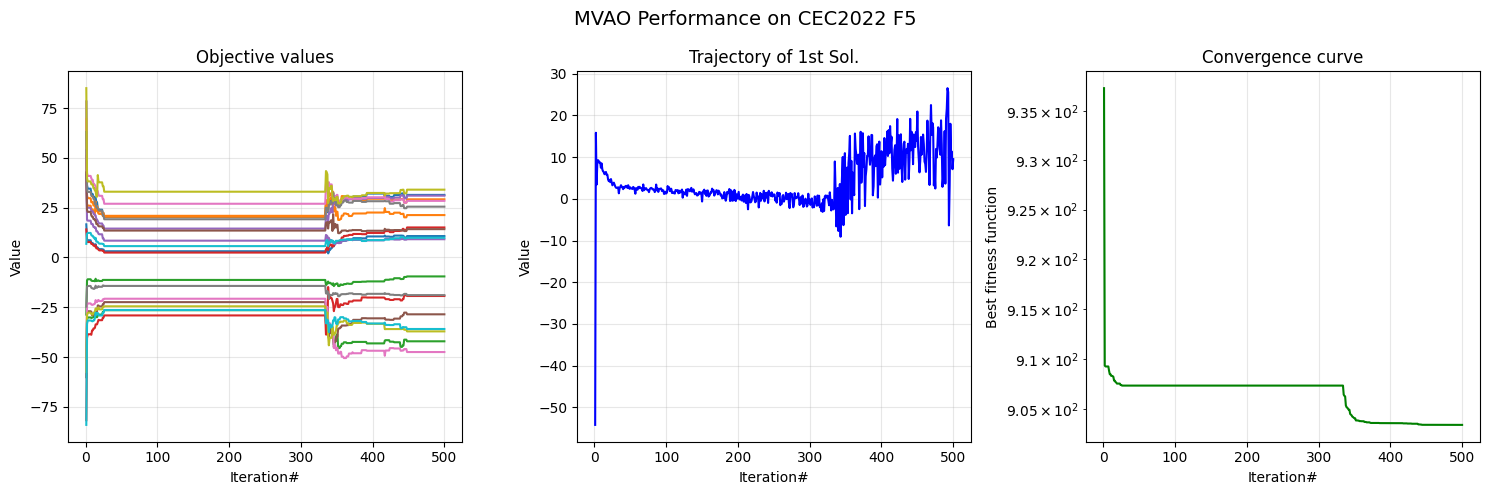

Running CEC2022 functions:  60%|██████    | 3/5 [00:21<00:14,  7.26s/it]

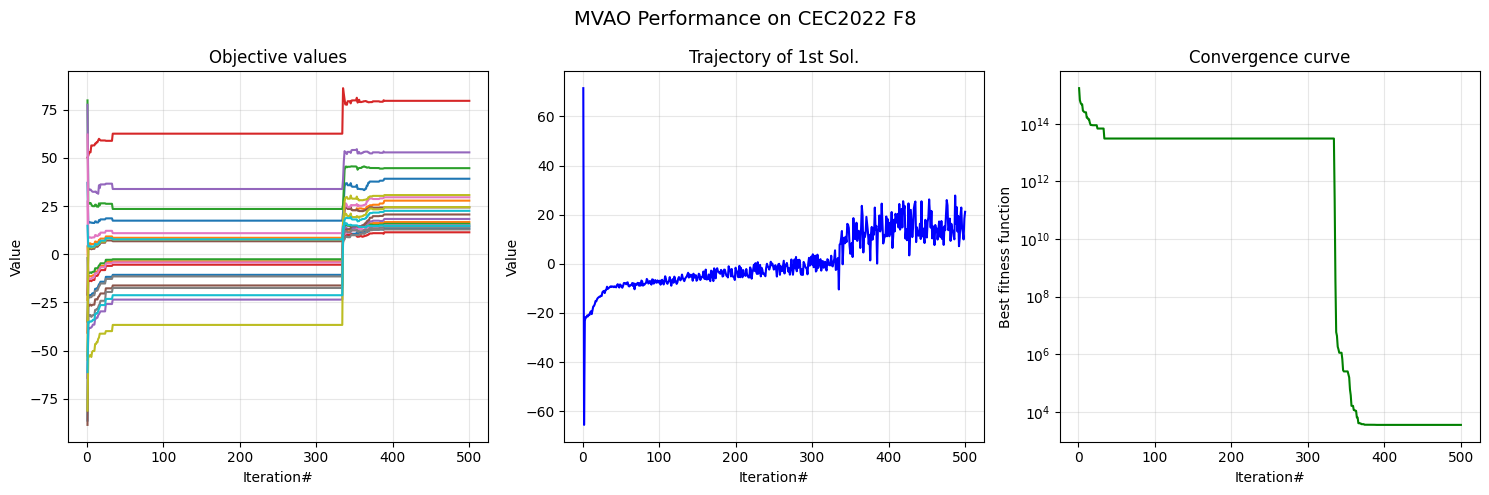

Running CEC2022 functions:  80%|████████  | 4/5 [01:27<00:30, 30.34s/it]

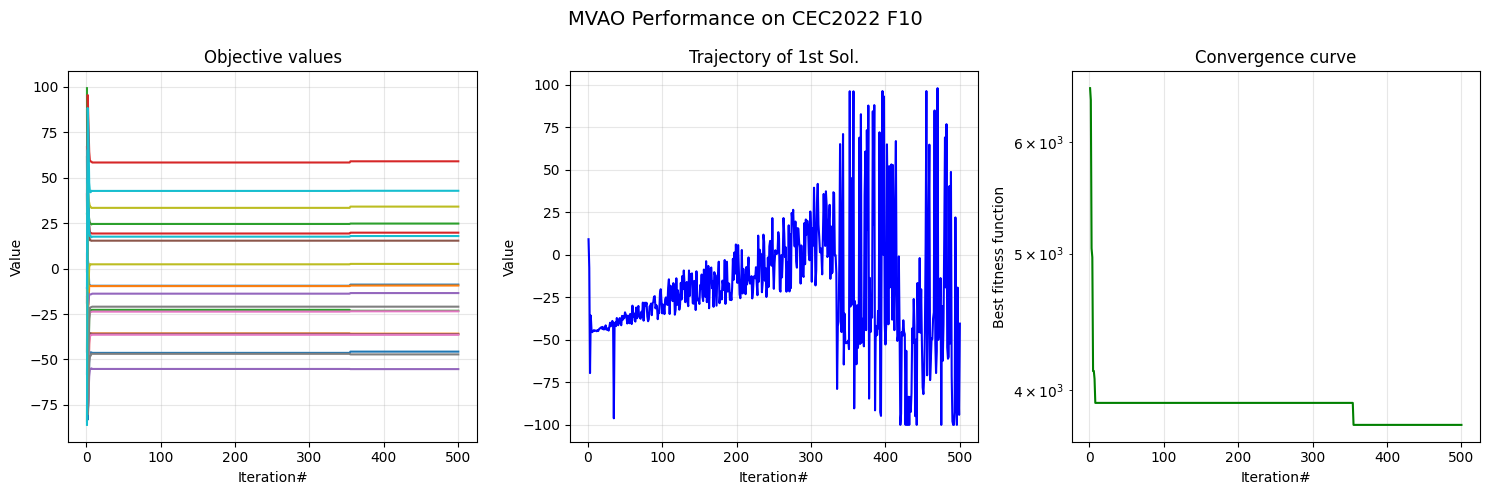

Running CEC2022 functions: 100%|██████████| 5/5 [01:41<00:00, 20.35s/it]


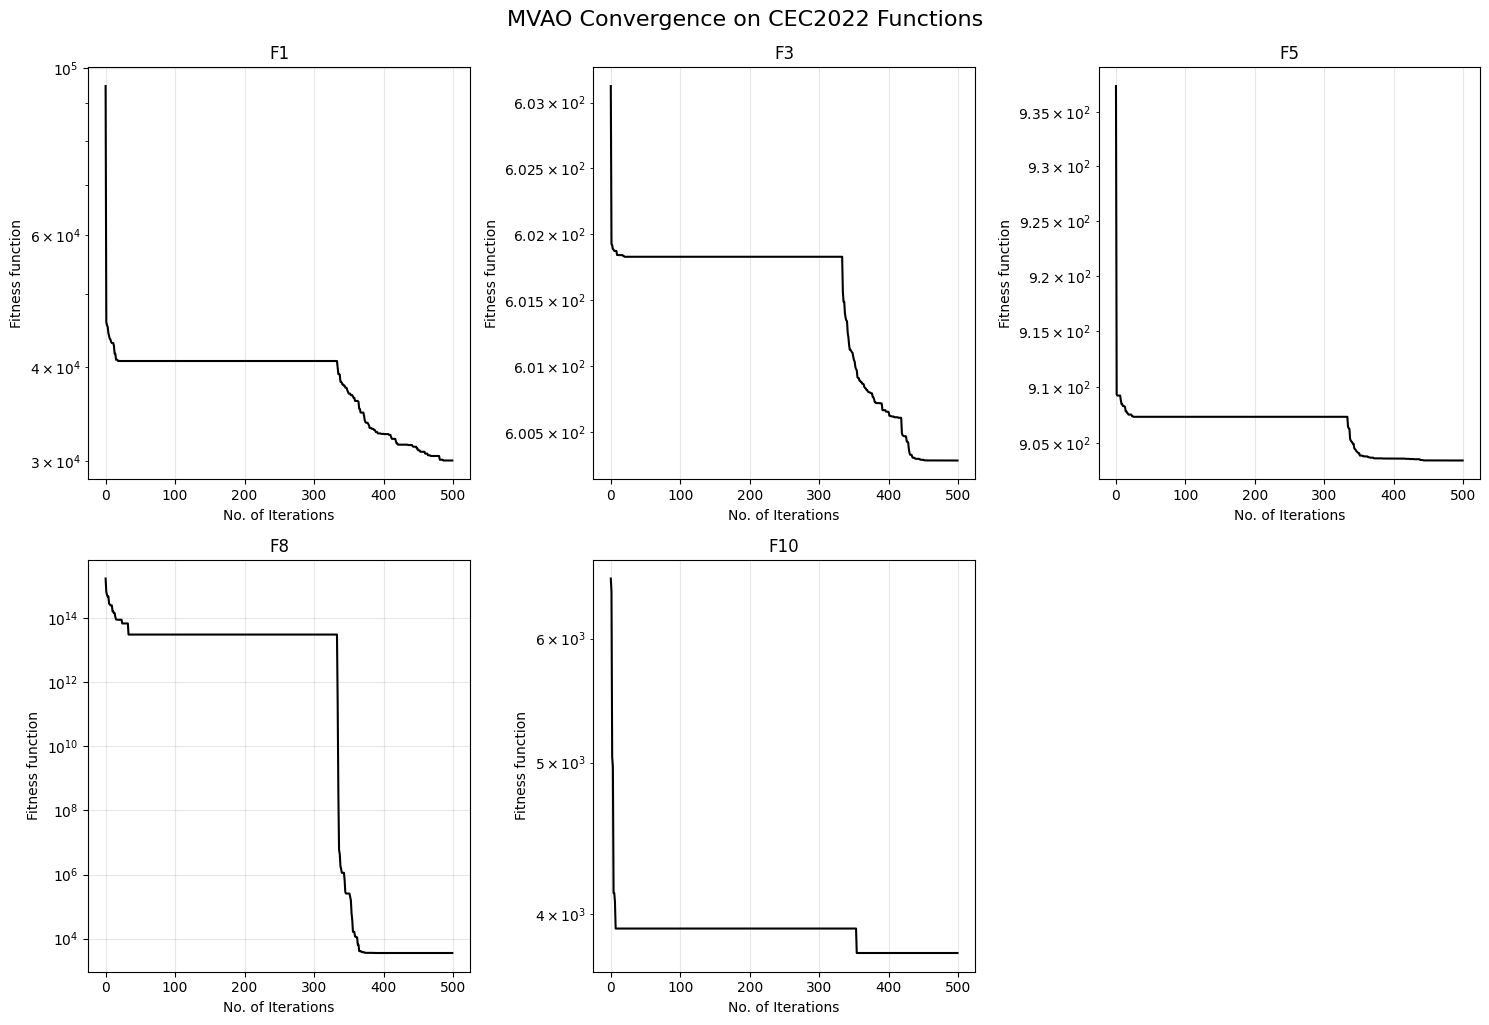

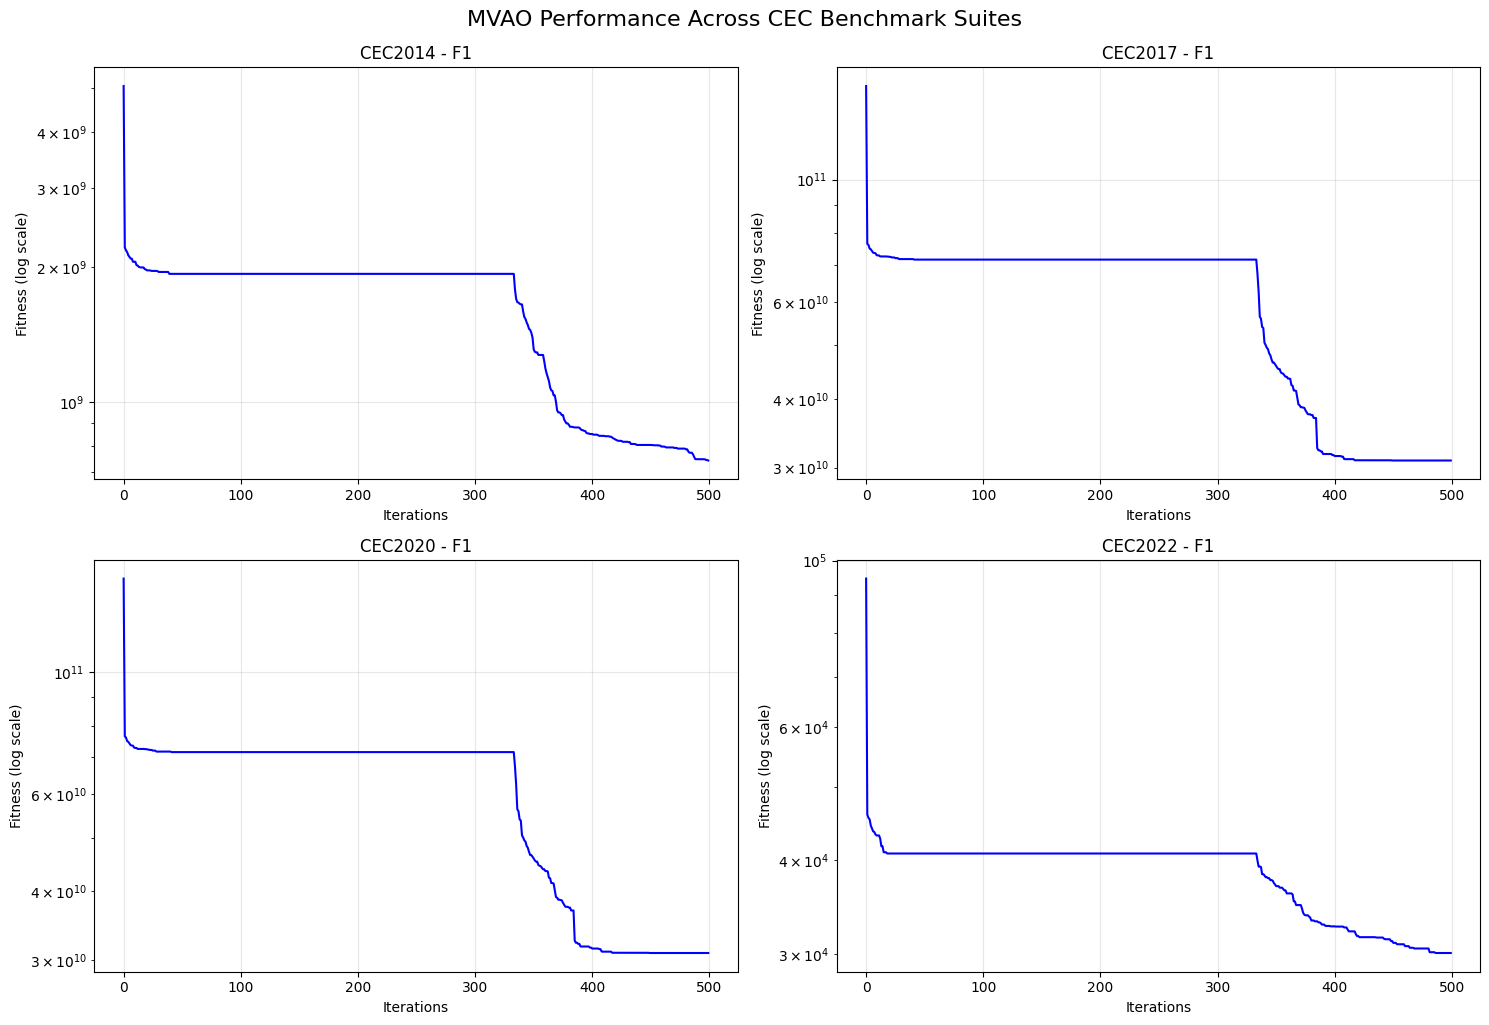


All visualizations saved to mvao_visualization_results/


In [11]:
def main():
    """Run experiments and generate visualizations for all CEC suites."""
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Define parameters
    max_iter = 500
    pop_size = 50
    runs = 1  # Set to 1 for detailed plots, increase for statistical significance
    
    # Directory to save results
    save_dir = "mvao_visualization_results"
    
    # Define functions to evaluate for each suite
    suite_configs = {
        'CEC2014': {
            'dims': 30,
            'funcs': [1, 3, 9, 13, 21, 25]  # Select representative functions
        },
        'CEC2017': {
            'dims': 30,
            'funcs': [1, 5, 9, 14, 21, 28]
        },
        'CEC2020': {
            'dims': 30,
            'funcs': [1, 3, 5, 7, 10]
        },
        'CEC2022': {
            'dims': 20,  # Max dimension for CEC2022
            'funcs': [1, 3, 5, 8, 10]
        }
    }
    
    # Run experiments for each suite
    all_results = {}
    for suite, config in suite_configs.items():
        print(f"\nRunning experiments for {suite}...")
        results = run_cec_experiments(
            suite, 
            config['funcs'],
            dimensions=config['dims'],
            max_iter=max_iter,
            pop_size=pop_size,
            runs=runs,
            save_dir=save_dir
        )
        all_results[suite] = results
    
    # Create a combined visualization for all suites
    plt.figure(figsize=(15, 10))
    
    for i, (suite, results) in enumerate(all_results.items()):
        # Select one representative function from each suite
        func_name = list(results.keys())[0]
        plt.subplot(2, 2, i+1)
        
        iterations = np.arange(len(results[func_name]))
        plt.semilogy(iterations, results[func_name], 'b-', linewidth=1.5)
        
        plt.title(f"{suite} - {func_name}")
        plt.xlabel("Iterations")
        plt.ylabel("Fitness (log scale)")
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle("MVAO Performance Across CEC Benchmark Suites", y=1.02, fontsize=16)
    plt.savefig(os.path.join(save_dir, "all_suites_comparison.png"), dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"\nAll visualizations saved to {save_dir}/")

if __name__ == "__main__":
    main()
